# Text Generation with Embeddings

Setup file with the necessary imports

In [2]:
import re
import tensorflow as tf
import numpy as np

from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics.pairwise import cosine_similarity


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Import the dataset

The dataset is the book "" as a textfile. The orginal text from gutenberg is available at [http://www.gutenberg.org/ebooks/1661](http://www.gutenberg.org/ebooks/1661). The text contained a header that was removed in the this project.

In [4]:
filename = 'data/raw_text/aesop_fable.txt'

with open(filename, 'r', encoding='utf-8-sig') as f:
    raw_text = f.read()

In [5]:
print(raw_text[:10])

The Wolf A


## Import GloVe Embeddings

The GloVe embeddings are available at [http://nlp.stanford.edu/data/glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip). The embeddings are in a textfile and can be loaded using the following code. The embeddings used here are the 50 dimensional embeddings and are stored in a dictionary. There are also two other dictionaries that contain the word to index and index to word mappings to make the embeddings easy to lookup by word and be able to convert tokens to words.

In [6]:
file_name = "data/GloVe/glove.6B.50d.txt"

embedding = {}
idx_to_word = {}
word_to_idx = {}
bad_lines = 0

with open(file_name, 'r', encoding='UTF-8') as f:
    for idx, line in enumerate(f):
        try:
            line = line.strip()
            match_obj = re.match(r'([^\s]+)', line)
            word = match_obj.group(1)
            word_len = len(word)
            word_vec = line[word_len:].replace('\n', '')

            embed = word_vec.strip()
            embed = embed.split()
            embed = np.array(embed, dtype=np.float32)
            
            embedding[idx] = [embed]
            idx_to_word[idx] = word.strip()
            word_to_idx[word.strip()] = idx
        except:
            bad_lines += 1

print(f'Bad lines: {bad_lines}')

Bad lines: 0


In [7]:
w1 = 'waiter'
w2 = 'waitress'

w1_embed = embedding[word_to_idx[w1]]
w2_embed = embedding[word_to_idx[w2]]
cosine_similarity(w1_embed, w2_embed)

array([[0.8778121]], dtype=float32)

## Generate the Dataset

The dataset for this project is the text file sliced into arrays of 20 words and the label is the next word in the array. The input data is stored initially in three lists:

- `x`: a list of 20 words
- `x_token`: a list of the tokenized words (as BERT tokens)
- `x_mask`: list containing the mask for the input data
- `y`: the next word in the array as a BERT token

Even though the GloVe embedding dataset contains 400,000 words, BERT tokens are stemmed and contain unconventional words with artifacts like `#`. To ensure that an embedding can be generated for every predicted word, a out-of-vocabulary words are replaced with the word "umm". We'll see how this goes.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
def get_embedding(word):
    if word in word_to_idx:
        return embedding[word_to_idx[word]]
    else:
        return embedding[word_to_idx['umm']]

In [10]:
def generate_sequences(text, seq_length):
    tokens = tokenizer.tokenize(text)
    num_sequences = len(tokens) - seq_length
    
    x = []
    x_token = np.zeros((num_sequences, seq_length+2))
    x_mask = np.zeros((num_sequences, seq_length+2))
    y_token = np.zeros((num_sequences, 50), dtype=np.float32)

    for i in range(0, num_sequences):
        seq = tokens[i:i + seq_length]
        input = tokenizer.encode_plus(seq, max_length=seq_length+2, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
        
        x.append(seq)
        x_token[i, :] = input['input_ids']
        x_mask[i, :] = input['attention_mask']
        y_token[i, :] = get_embedding(tokens[i + seq_length])[0]

    print(f'Number of sequences: {num_sequences}')

    return x, x_token, x_mask, y_token, num_sequences

seq_length = 20
x, x_token, x_mask, y_token, num_sequences = generate_sequences(raw_text, seq_length)

2021-11-18 16:04:15.302823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:04:15.332987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:04:15.333510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 16:04:15.335444: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of sequences: 55180


In [11]:
print(x[:2])
print(x_token[:2])
print(x_mask[:2])
print(y_token[:2])

[['the', 'wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to'], ['wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to', 'lay']]
[[  101.  1996.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.
   1037. 12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.
   2000.   102.]
 [  101.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.  1037.
  12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.  2000.
   3913.   102.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 1.1417e+00  4.6283e-01  3.1850e-01 -1.0938e+00  7.7268e-01 -8.5313e-03
  -2.7627e-01  1.9700e-01  2.5137e-01 -7.4092e-01 -5.2680e-01  6.7512e-02
  -6.1951e-01  3.2295e-01 -2.9231e-01  2.7597e-01 -2.1011e-02 -4.3145e-01
   8.1964

## Convert individual datasets into a single dataset

In order to use the BERT layer as input for the model, the tokens and masks need to be combined into a single input and given keys that match the name of the input layers. The dataset is then shuffled, batched, and split into training, validation, and test sets.

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((x_token, x_mask, y_token))
dataset.take(1)

<TakeDataset shapes: ((22,), (22,), (50,)), types: (tf.float64, tf.float64, tf.float32)>

In [13]:
def combine_input_mask(input_id, mask, y_token):
    return {'input_ids': input_id, 'attention_mask': mask}, y_token

dataset = dataset.map(combine_input_mask)
dataset.take(1)


<TakeDataset shapes: ({input_ids: (22,), attention_mask: (22,)}, (50,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [31]:
split = 0.8
sample_size = int((num_sequences // batch_size) * split)
ds_train = dataset.take(sample_size)
dataset_validation = dataset.skip(sample_size)

test_split = 0.5
testset_size = len(list(dataset_validation))
val_sample_size = int(testset_size * test_split)
ds_val = dataset_validation.take(val_sample_size)
ds_test = dataset_validation.skip(val_sample_size)
print(f'tensor: {ds_train.take(1)}\nsize: {len(list(ds_train))}')
print(f'tensor: {ds_val.take(1)}\nsize: {len(list(ds_val))}')
print(f'tensor: {ds_test.take(1)}\nsize: {len(list(ds_test))}')

tensor: <TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>
size: 1379
tensor: <TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>
size: 172
tensor: <TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>
size: 173


## Construct the model

The model uses uncases BERT as the encoder and uses a linear layer to generate the next word. The model is trained using the Adam optimizer and the cross-entropy loss. Usually the model is categorical and uses softmax for the last Dense logit layer, but in this case we are building a regression model and want the output to most closely match the true word embedding.

In [32]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

2021-11-18 16:21:56.263304: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further tr

In [33]:
input_layer = Input(shape=(seq_length+2,), name='input_ids', dtype=tf.int32)
mask_layer = Input(shape=(seq_length+2,),
                   name='attention_mask', dtype=tf.int32)

embedding_layer = bert.bert(input_layer, attention_mask=mask_layer)[1]

out = Dense(1024, activation='relu')(embedding_layer)
out = Dropout(0.2)(out)
out = Dense(50)(out)

model = Model(inputs=[input_layer, mask_layer], outputs=out)

model.layers[2].trainable = False

optimizer = SGD(learning_rate=0.00009, decay=1e-6)
model.compile(optimizer=optimizer,
              loss=tf.losses.mean_squared_error, metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 22)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 22)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 22,                                            

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(ds_train, validation_data=ds_val,
                    batch_size=64, epochs=100, shuffle=True, verbose=1, callbacks=[es])

Epoch 1/100
1379/1379 [==============================] - 58s 39ms/step - loss: 0.4908 - accuracy: 0.6605 - val_loss: 0.3448 - val_accuracy: 0.7889
Epoch 2/100
1379/1379 [==============================] - 49s 36ms/step - loss: 0.3618 - accuracy: 0.8228 - val_loss: 0.3208 - val_accuracy: 0.7943
Epoch 3/100
1379/1379 [==============================] - 54s 39ms/step - loss: 0.3461 - accuracy: 0.8274 - val_loss: 0.3172 - val_accuracy: 0.7998
Epoch 4/100
1379/1379 [==============================] - 55s 40ms/step - loss: 0.3374 - accuracy: 0.8328 - val_loss: 0.3086 - val_accuracy: 0.8049
Epoch 5/100
1379/1379 [==============================] - 49s 35ms/step - loss: 0.3317 - accuracy: 0.8346 - val_loss: 0.3107 - val_accuracy: 0.8009
Epoch 6/100
1379/1379 [==============================] - 47s 34ms/step - loss: 0.3261 - accuracy: 0.8373 - val_loss: 0.3094 - val_accuracy: 0.7958
Epoch 7/100
1379/1379 [==============================] - 47s 34ms/step - loss: 0.3228 - accuracy: 0.8374 - val_loss: 0

In [35]:
loss, accuracy = model.evaluate(ds_test, verbose=0)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 80.51%


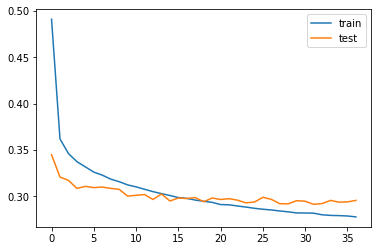

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()